In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.path as mpath


import warnings; warnings.simplefilter('ignore')

In [23]:
#########################
######### DICTIONARIES DEFINITION 
#########################
reg = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    }
}



Range_MLD = {
    'lab' : {
        'vmin' : 20, 
        'vmax' : 2000},
    'gul' : {
        'vmin' : 20, 
        'vmax' : 1000},
    'noe' : {
        'vmin' : 10, 
        'vmax' : 1600},
}


#Colorbar parameters
color_bar = {
    'cmap' : 'YlGnBu',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}



# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [24]:
def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


In [4]:
## Function to crop the dataset

## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    #ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    #ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)
    

In [5]:
def Hist_params(data_set, n_bins):
    """
        Hist_param is a function that generates an histogram for each time step
        of a DataArray.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset we are working on
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    heigth = np.empty(n_bins)
    
    for i in range(len(data_set.week)):
        d_frame = data_set[i].to_dataframe().dropna(how='all')
        #d_frame = data_set[i].dropna(dim='latitude', how='any')

        values = d_frame
        hist, bins = np.histogram(values, bins=n_bins, range=(mn, mx), normed=False)

        heigth = np.vstack((heigth, hist))
        
    h = np.delete(heigth, 0, 0)
    
    return(h)
    

def PDF_time(data_set, mini, maxi, n_bins, *limits):
    """
        PDF_time is a function that generates a 2D plot from histograms
        and time steps. This is the plot will have as 'x' axis values of MLD
        classes in meters, and the 'y' axis will have time dimensions. The 
        colors indicate the number of grid points in each MLD class.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset we are working on
            
        mini : float
            minimum value to create the 'y' axis
            
        maxi : float
            maximum value to create the 'y' axis
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    x = data_set.week
    y = np.arange(mini, maxi, abs((mini-maxi)/n_bins))
    X, Y = np.meshgrid(x, y)

    hist = Hist_params(data_set, n_bins)
    
    #Minimum and maximum values for the color bar
    vmin = hist.min()
    vmax = hist.max()

    fig, ax = plt.subplots()

    #ax.set_yscale("log", nonposy='clip')
    cs = ax.contourf(X, Y, np.log10(hist.T), 
                     np.linspace(np.log10(1.), np.log10(limits[1]), 14), 
                     cmap='viridis', extend='max')
    
    #cs = ax.contourf(X, Y, hist.T, norm=mpl.colors.LogNorm(), cmap='plasma', snap=True)
    #ax.set_title('Gulf Stream MLD distribution')

    cb = fig.colorbar(cs, ax=ax, orientation='vertical')
    #minorticks = p.norm(np.arange(1, 10, 2))
    #cb.ax.xaxis.set_ticks(minorticks, minor=True)
    
    cb.set_label('log$_{10}$ N')
    #ax.set_clim(10., 4000.)
    
    ##Deberia regresar o no la figura? -> No.
    #H = ax.hist2d(x, y, bins=40, norm=LogNorm())
    #fig.colorbar(H[3], ax=ax)
    
    
def Save_fig(name):
    fig.savefig(name, bbox_inches='tight')
    

def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [37]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '/home/lgarcia/Documents/Other_datasets/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'Heat-Monthly.nc'
fl_n15 = 'ARMOR_*.nc'


c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
c_armor15 = Masking(c_armor15, c_armor15.to[0,18])
c_armor15 = Crops('noa', c_armor15, reg_ext)

heat = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
heat = heat.reindex(latitude=heat.latitude[::-1])
heat = Crops('noa', heat, reg_ext)

In [26]:
fact = 86400.

In [27]:
heat = heat.reindex(latitude=c_armor15.latitude, longitude=c_armor15.longitude, method='nearest')

In [28]:
heat

<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 560, time: 168)
Coordinates:
  * latitude   (latitude) float32 10.125 10.375 10.625 ... 84.375 84.625 84.875
  * longitude  (longitude) float32 -89.875 -89.625 -89.375 ... 49.625 49.875
  * time       (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2018-12-01
Data variables:
    slhf       (time, latitude, longitude) float32 dask.array<shape=(168, 300, 560), chunksize=(168, 300, 560)>
    ssr        (time, latitude, longitude) float32 dask.array<shape=(168, 300, 560), chunksize=(168, 300, 560)>
    str        (time, latitude, longitude) float32 dask.array<shape=(168, 300, 560), chunksize=(168, 300, 560)>
    sshf       (time, latitude, longitude) float32 dask.array<shape=(168, 300, 560), chunksize=(168, 300, 560)>
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-26 13:05:41 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [29]:
net = (heat.slhf + heat.ssr + heat.str + heat.sshf)

In [30]:
#heat.coords['longitude'] = (('longitude'), c_armor15.longitude.values)
#heat.coords['latitude'] = (('latitude'), c_armor15.latitude.values)

In [31]:
net_mean = net.mean(dim='time')/86400.

In [32]:
net_mean

<xarray.DataArray (latitude: 300, longitude: 560)>
dask.array<shape=(300, 560), dtype=float32, chunksize=(300, 560)>
Coordinates:
  * latitude   (latitude) float32 10.125 10.375 10.625 ... 84.375 84.625 84.875
  * longitude  (longitude) float32 -89.875 -89.625 -89.375 ... 49.625 49.875

<IPython.core.display.Javascript object>


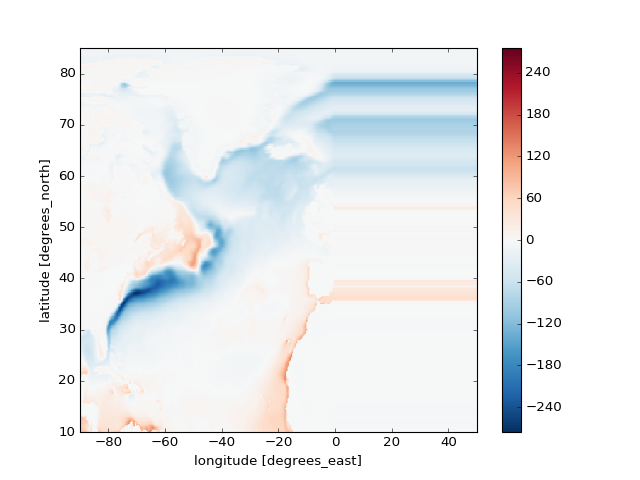

In [33]:
%matplotlib notebook

plt.close()
net_mean.plot()
plt.show()

In [29]:
reg = 'gul'
gulf = Crops(reg, net_mean, reg_ext)

hn_min = gulf.min(skipna=True).values
hn_max = gulf.max(skipna=True).values

print(hn_min, hn_max)

-275.7399 116.96466


<IPython.core.display.Javascript object>


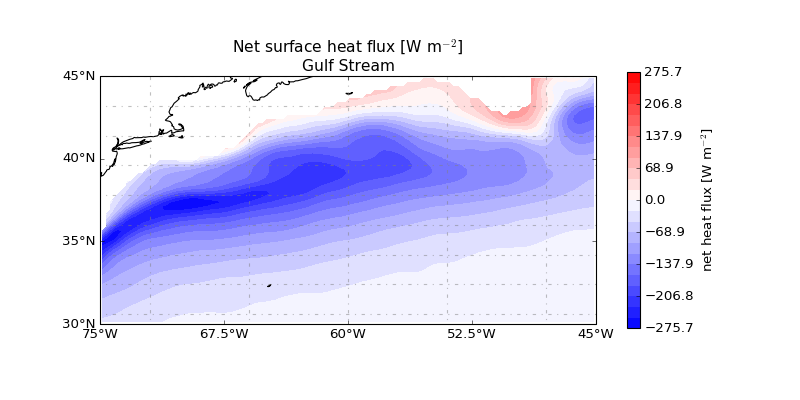

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [30]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

# Variables to plot
mapping_var = gulf.where(c_armor15.mask==1)  # In the colormap


cb_label = 'net heat flux [W m$^{-2}$]'    # Label for colorbar
cmap = 'bwr'
levels = np.linspace(hn_min, -hn_min, 25)


## Title for the figure
fig_title = 'Net surface heat flux [W m$^{-2}$] \nGulf Stream'  

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(10,5)) 

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither')

cbar = fig.colorbar(contr1, ax=ax, shrink=0.8, orientation='vertical',
                    label=cb_label) 

#cbar.set_clim(vmin=0., vmax=300.)
ax.set_title(fig_title, fontsize=14)

plt.savefig(dir_o + 'Gulf-heat.png', bbox_inches='tight')
plt.show()

In [31]:
reg = 'lab'
lab = Crops(reg, net_mean, reg_ext)


hn_min_l = lab.min(skipna=True).values
hn_max_l = lab.max(skipna=True).values

print(hn_min_l, hn_max_l)

-131.82326 51.217102


<IPython.core.display.Javascript object>


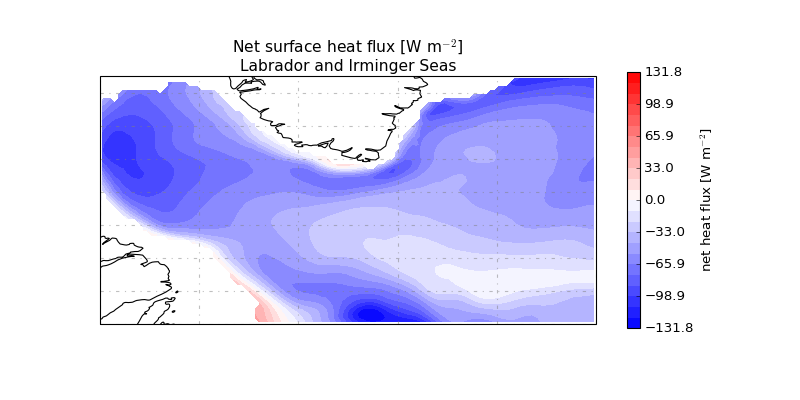

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [32]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(lab)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

# Variables to plot
mapping_var = lab.where(c_armor15.mask==1)  # In the colormap

cb_label = 'net heat flux [W m$^{-2}$]'    # Label for colorbar
cmap = 'bwr'
levels = np.linspace(hn_min_l, -hn_min_l, 25)


## Title for the figure
fig_title = fig_title = 'Net surface heat flux [W m$^{-2}$] \nLabrador and Irminger Seas'    

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(10,5)) 

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither')

cbar = fig.colorbar(contr1, ax=ax, shrink=0.8, orientation='vertical',
                    label=cb_label) 

#cbar.set_clim(vmin=0., vmax=300.)
ax.set_title(fig_title, fontsize=14)

plt.savefig(dir_o + 'Lab-heat.png', bbox_inches='tight')
plt.show()

In [38]:
reg = 'noe'
noe = Crops(reg, net_mean, reg_ext)


hn_min_n = noe.min(skipna=True).values
hn_max_n = noe.max(skipna=True).values

print(hn_min_n, hn_max_n)

-75.374626 25.639444


<IPython.core.display.Javascript object>


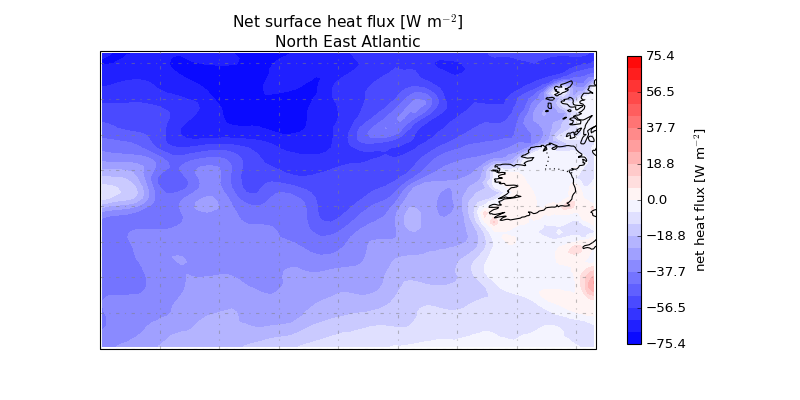

In [39]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(noe)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

# Variables to plot
mapping_var = noe#.where(c_armor15.mask==1)   # In the colormap

cb_label = 'net heat flux [W m$^{-2}$]'    # Label for colorbar
cmap = 'bwr'
levels = np.linspace(hn_min_n, -hn_min_n, 25)


## Title for the figure
fig_title = fig_title = 'Net surface heat flux [W m$^{-2}$] \nNorth East Atlantic'     

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(10,5)) 

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither')

cbar = fig.colorbar(contr1, ax=ax, shrink=0.9, orientation='vertical',
                    label=cb_label) 

#cbar.set_clim(vmin=0., vmax=300.)
ax.set_title(fig_title, fontsize=14)

#plt.savefig(dir_o + 'Noe-heat.png', bbox_inches='tight')
plt.show()

In [41]:
reg = 'nor'
nor = Crops(reg, net_mean, reg_ext)


hn_min_nr = nor.min(skipna=True).values
hn_max_nr = nor.max(skipna=True).values

print(hn_min_nr, hn_max_nr)

-134.10739 17.942554


<IPython.core.display.Javascript object>


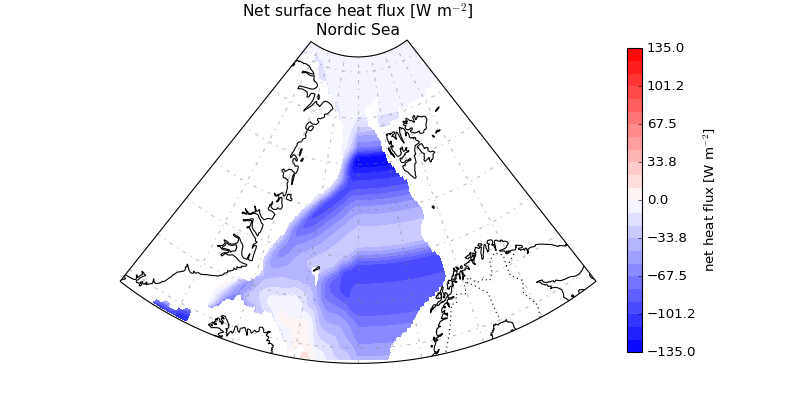

In [44]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(nor)

projection = projection = ccrs.AlbersEqualArea(central_longitude=0,
                            central_latitude=75,
                            standard_parallels=(lat1, lat2))
data_crs = ccrs.PlateCarree()
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

# Variables to plot
mapping_var = nor.where(c_armor15.mask==1)   # In the colormap

cb_label = 'net heat flux [W m$^{-2}$]'    # Label for colorbar
cmap = 'bwr'
levels = np.linspace(-135., 135., 25)


## Title for the figure
fig_title = fig_title = 'Net surface heat flux [W m$^{-2}$] \nNordic Sea'     

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(10,5)) 

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither',
                    transform=data_crs)

cbar = fig.colorbar(contr1, ax=ax, shrink=0.95, orientation='vertical',
                    label=cb_label)


vertices = [(lon, lat1) for lon in range(int(lon1), int(lon2+1), 1)]+ \
           [(lon, lat2) for lon in range(int(lon2), int(lon1+1), -1)]

boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=data_crs)

ax.set_title(fig_title, fontsize=14)

plt.savefig(dir_o + 'Nor-heat.png', bbox_inches='tight')
plt.show()